In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pickle
from astropy.table import Table
from astropy.io import fits

import sys
sys.path.insert(0, "../")

import velociraptor
from mpl_utils import mpl_style

%matplotlib inline
plt.style.use(mpl_style)

In [3]:
data = fits.open("../data/gaia-sources-for-npm.fits")[1].data

In [13]:
def get_rv_completeness(x, semilogx, equidensity, N_bins,
                        x_min=None, x_max=None):

    y = data["radial_velocity"]
    
    x_finite = np.isfinite(x)
    y_finite = np.isfinite(y)
    if x_min is None:
        x_min = np.min(x[x_finite])
    if x_max is None:
        x_max = np.max(x[x_finite])
    
    mask = (x_max >= x) * (x >= x_min)
    x_finite *= mask
    y_finite *= mask
    
    p = np.linspace(0, 100, N_bins)
    if equidensity and semilogx:
        bins = 10**np.percentile(np.log10(x[x_finite]), p)
        
    elif equidensity and not semilogx:
        bins = np.percentile(x[x_finite], p)
    
    elif not equidensity and semilogx:
        bins = np.logspace(np.log10(x_min), np.log10(x_max), N_bins)
    
    elif not equidensity and not semilogx:
        bins = np.linspace(x_min, x_max, N_bins)
    
    numerator, _ = np.histogram(x[x_finite * y_finite], bins=bins)
    denominator, _ = np.histogram(x[x_finite], bins=bins)
    f = numerator/denominator.astype(float)
    
    # Pretty sure this ~has~ to be wrong.
    f_err = f / np.diff(bins) * np.sqrt(
            (np.sqrt(numerator)/numerator)**2 + \
            (np.sqrt(denominator)/denominator)**2)

    return (bins, f, f_err, numerator, denominator)

In [31]:
def plot_rv_completeness(x, latex_label_name, semilogx, equidensity, N_bins, 
                         ax=None, title=None, x_min=None, x_max=None, 
                         valid_xrange=None, snap_xrange_to_nearest_bin_edge=False,
                         **kwargs):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    else:
        fig = ax.figure
        
    bins, f, f_err, num, den = get_rv_completeness(
        x, semilogx=semilogx, equidensity=equidensity,
        N_bins=N_bins, x_min=x_min, x_max=x_max)
    
    x = np.hstack([bins[0], np.repeat(bins[1:-1], 2), bins[-1]])
    x_mid = bins[:-1] + 0.5 * np.diff(bins)
    
    y = np.array(f).repeat(2)
    
    kwds = dict(linestyle="-", marker="None")
    kwds.update(kwargs)
    
    line = ax.plot(x, y, **kwds)
    ax.errorbar(x_mid, f, yerr=f_err, fmt="none", c=line[0].get_color())
    
    ax.set_ylabel(r"\textrm{fraction of sources with radial velocity}")
    ax.set_xlabel(latex_label_name)
    
    if semilogx:
        ax.semilogx()
        
    if valid_xrange is not None:
        lower, upper = valid_xrange
        if snap_xrange_to_nearest_bin_edge:
            mask = (bins >= lower) * (bins <= upper)
            lower = bins[mask][0]
            upper = bins[mask][-1]

            print("Updated valid range for {} is ({:.2f}, {:.2f})".format(
                latex_label_name, lower, upper))

        ax.axvspan(lower, upper, facecolor="#eeeeee", edgecolor="None", zorder=-1)
    
    return fig

In [89]:
# Apply ranges
valid_ranges = dict(
    bp_rp=(1.2, 2.3),
    phot_rp_mean_mag=(10, 12.15))

Updated valid range for \textrm{phot rp mean mag} is (10.16, 12.10)
Updated valid range for \textrm{phot rp mean mag} is (10.19, 11.96)


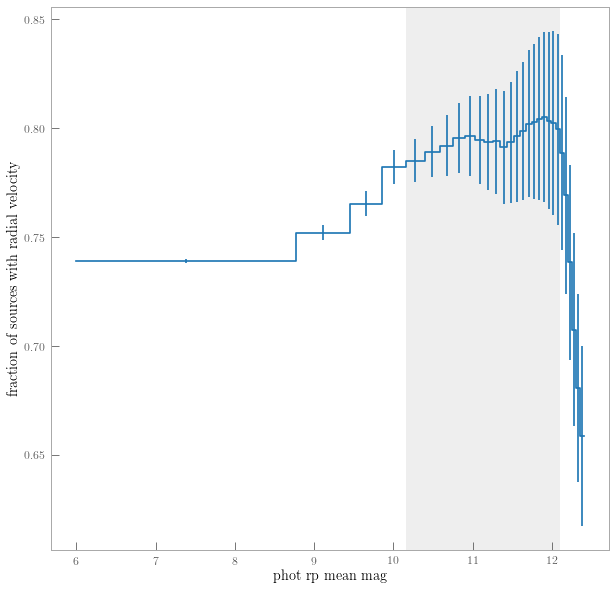

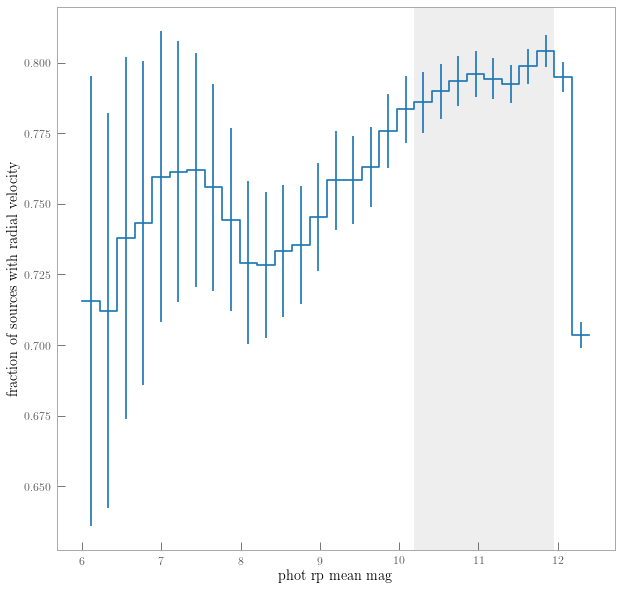

In [90]:
for equidensity in (True, False):
    fig = plot_rv_completeness(data["phot_rp_mean_mag"], r"\textrm{phot rp mean mag}",
                               semilogx=False, equidensity=equidensity, N_bins=30,
                               x_min=6, x_max=12.4, valid_xrange=valid_ranges.get("phot_rp_mean_mag", None),
                               snap_xrange_to_nearest_bin_edge=True)

/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in less_equal
  del sys.path[0]
/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in greater_equal
  del sys.path[0]


Updated valid range for \textrm{bp - rp} is (1.21, 2.18)
Updated valid range for \textrm{bp - rp} is (1.22, 2.29)


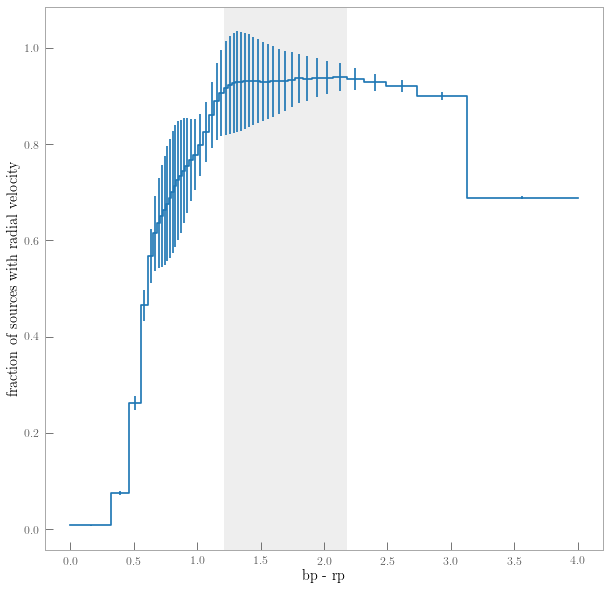

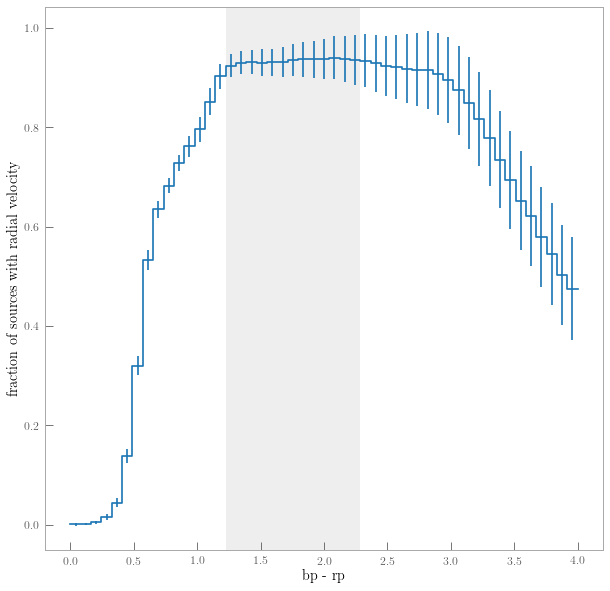

In [91]:
for equidensity in (True, False):
    fig = plot_rv_completeness(data["bp_rp"], r"\textrm{bp - rp}",
                               semilogx=False, equidensity=equidensity, N_bins=50,
                               x_min=0, x_max=4, valid_xrange=valid_ranges.get("bp_rp", None),
                               snap_xrange_to_nearest_bin_edge=True)

In [92]:
in_sb2_source_parameter_range = np.ones(len(data), dtype=bool)
for label_name, (lower_value, upper_value) in valid_ranges.items():
    if lower_value is not None:
        in_sb2_source_parameter_range *= (data[label_name] >= lower_value)
    
    if upper_value is not None:
        in_sb2_source_parameter_range *= (upper_value >= data[label_name])
        
finite_rv = np.isfinite(data["radial_velocity"])
is_sb2 = in_sb2_source_parameter_range * ~finite_rv

/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater_equal
  after removing the cwd from sys.path.
/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less_equal
  import sys


In [93]:
N_in_sb2_sp_range = sum(in_sb2_source_parameter_range)
N_is_sb2 = sum(is_sb2)

In [94]:
print("""
Total sources in valid SB2 range: {0:.0f}
Numer of sources in that range without an RV: {1:.0f}
""".format(N_in_sb2_sp_range, N_is_sb2))


Total sources in valid SB2 range: 2258427
Numer of sources in that range without an RV: 215278



In [95]:
# Plot the completeness fraction across the H-R diagram.
def plot_density_fraction(x, y, N_bins=150, 
                          min_points_per_bin=5, x_min=None, x_max=None, 
                          y_min=None, y_max=None, ax=None, xlabel=None, 
                          ylabel=None, figsize=(8, 8), colorbar=True,
                          mask=None, **kwargs):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)
    else:
        fig = ax.figure
        
    finite = np.isfinite(x * y)
    if x_min is not None:
        finite *= (x >= x_min)
    if x_max is not None:
        finite *= (x_max >= x)
    if y_min is not None:
        finite *= (y >= y_min)
    if y_max is not None:
        finite *= (y_max >= y)

    den = finite
    if mask is not None:
        den *= mask
        
    num = (~finite_rv) * den

    H_all, xedges, yedges = np.histogram2d(x[den], y[den],
        bins=N_bins)

    H_bin, _, __ = np.histogram2d(x[num], y[num],
        bins=(xedges, yedges))


    H = H_bin/H_all.astype(float)
    H[H_all < min_points_per_bin] = np.nan

    kwds = dict(
        aspect=np.ptp(xedges)/np.ptp(yedges), 
        extent=(xedges[0], xedges[-1], yedges[-1], yedges[0]),
        cmap="inferno",
    )
    kwds.update(kwargs)

    image = ax.imshow(H.T, **kwds)
    if xlabel is not None:
        ax.set_xlabel(xlabel)
    if ylabel is not None:
        ax.set_ylabel(ylabel)  

    if colorbar:
        cax = fig.add_axes([0.90, 0.125, 0.05, 0.75])

        cbar = plt.colorbar(image, cax=cax, orientation="vertical")
        cbar.set_label(r"\textrm{fraction of stars without radial velocity}")
    
    return fig


/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.
/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater_equal
  
/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in less_equal
  app.launch_new_instance()
/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in greater_equal
/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less_equal
/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


{'bp_rp': (1.2, 2.3), 'phot_rp_mean_mag': (10, 12.15)}


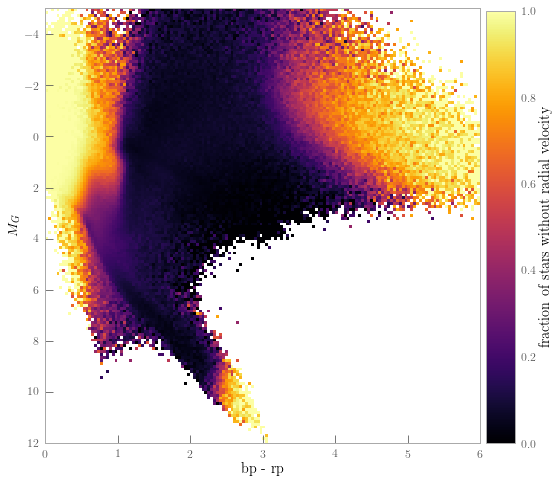

In [233]:
absolute_g_mag = data["phot_g_mean_mag"] + 5 * np.log10(data["parallax"]/100.0)
fig = plot_density_fraction(data["bp_rp"], absolute_g_mag, 
                            N_bins=150,
                            xlabel=r"\textrm{bp - rp}", ylabel=r"$M_G$",
                            x_min=0, x_max=6, y_min=-5, y_max=12,
                            cmap="inferno",
                            mask=None)
print(valid_ranges)

/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater_equal
  
/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in less_equal
  app.launch_new_instance()
/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in greater_equal
/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less_equal
/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


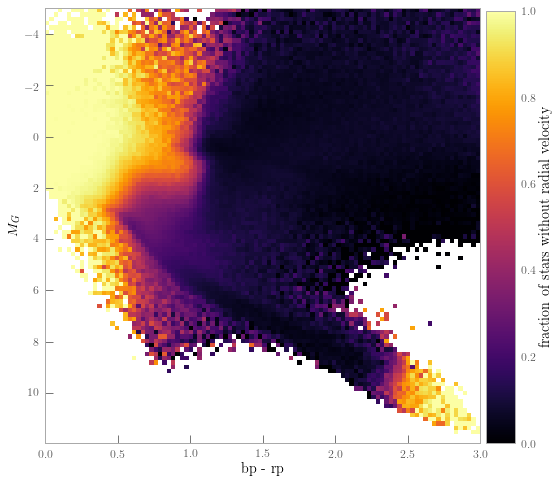

In [187]:
fig = plot_density_fraction(data["bp_rp"], absolute_g_mag, 
                            N_bins=100,
                            xlabel=r"\textrm{bp - rp}", ylabel=r"$M_G$",
                            x_min=0, x_max=3, y_min=-5, y_max=12,
                            cmap="inferno",
                            mask=None)


/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


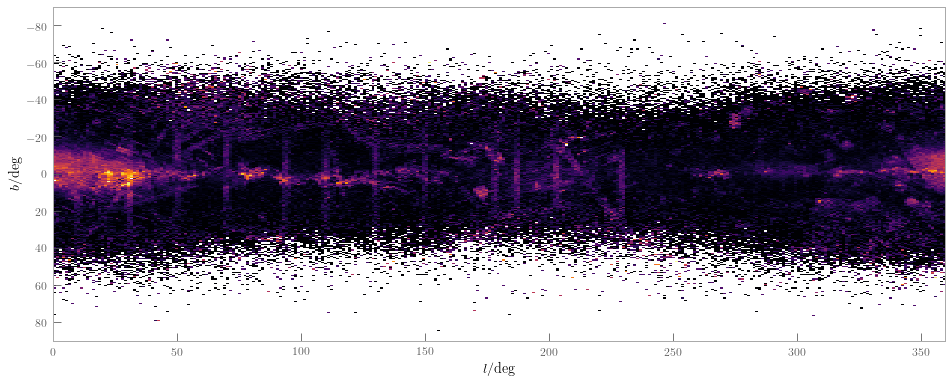

In [99]:
fig = plot_density_fraction(data["l"], data["b"], N_bins=300,
                            xlabel=r"$l / \mathrm{deg}$",
                            ylabel=r"$b / \mathrm{deg}$",
                            aspect=0.75, colorbar=False, figsize=(16, 8),
                            mask=in_sb2_source_parameter_range)


/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


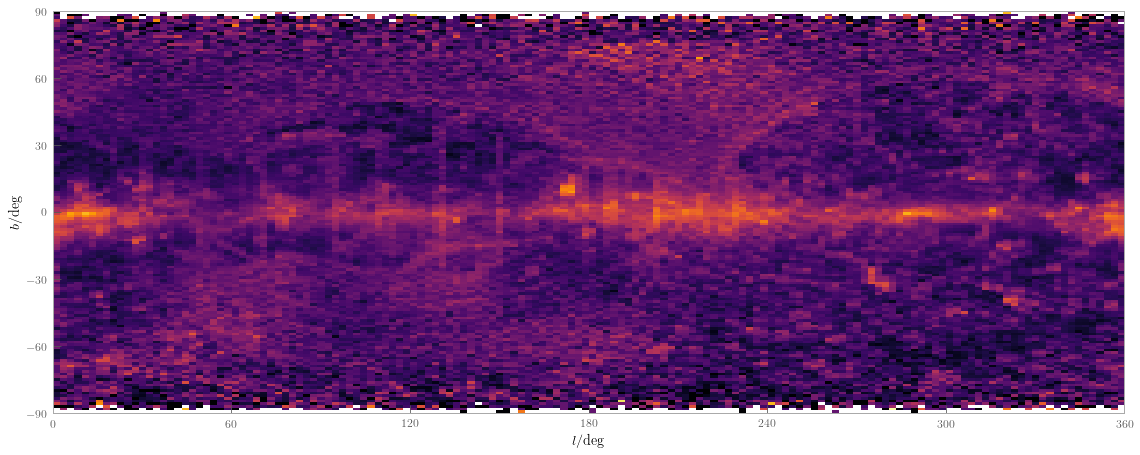

In [105]:
fig = plot_density_fraction(data["l"], data["b"], N_bins=(150, 150),
                            xlabel=r"$l / \mathrm{deg}$",
                            ylabel=r"$b / \mathrm{deg}$",
                            aspect=0.75, colorbar=False, figsize=(16, 8),
                            cmap="inferno")
fig.axes[0].set_xlim(0, 360)
fig.axes[0].set_ylim(-90, 90)
fig.axes[0].xaxis.set_major_locator(MaxNLocator(6))
fig.axes[0].yaxis.set_major_locator(MaxNLocator(6))
fig.tight_layout()

/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


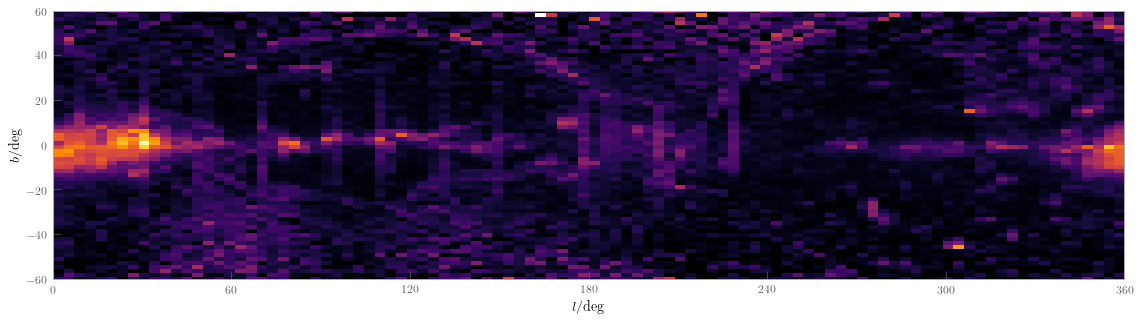

In [109]:
B = 100
fig = plot_density_fraction(data["l"], data["b"], N_bins=(B, B),
                            xlabel=r"$l / \mathrm{deg}$",
                            ylabel=r"$b / \mathrm{deg}$",
                            aspect=0.75, colorbar=False, figsize=(16, 8),
                            cmap="inferno", mask=in_sb2_source_parameter_range)
fig.axes[0].set_xlim(0, 360)
fig.axes[0].set_ylim(-60, 60)
fig.axes[0].xaxis.set_major_locator(MaxNLocator(6))
fig.axes[0].yaxis.set_major_locator(MaxNLocator(6))
fig.tight_layout()

In [100]:
from matplotlib.ticker import MaxNLocator
def plot_average_grid_value(x, y, z, bins=(100, 100), function=np.nanmedian,
                            ax=None, xlabel=None, ylabel=None, zlabel=None,
                            subsample=None, colorbar=True, figsize=(16, 8), **kwargs):
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)
    else:
        fig = ax.figure
        
    if subsample is not None:
        indices = np.random.choice(len(x), subsample, replace=False)
        x_, y_, z_ = (x[indices], y[indices], z[indices])
    else:
        x_, y_, z_ = x, y, z
    H, xedges, yedges = np.histogram2d(x_, y_, bins=bins)
    
    x_indices = np.digitize(x_, xedges) - 1
    y_indices = np.digitize(y_, yedges) - 1
    
    Z = np.nan * np.ones_like(H) 
    for i in range(xedges.size - 1):
        for j in range(yedges.size - 1):
            match = (x_indices == i) * (y_indices == j)
            try:
                _ = function(z_[match])
                
            except ValueError:
                continue
                
            else:
                Z[i, j] = _

    imshow_kwds = dict(
        aspect=np.ptp(xedges)/np.ptp(yedges), 
        extent=(xedges[0], xedges[-1], yedges[-1], yedges[0]),
        cmap="viridis"
    )
    imshow_kwds.update(kwargs)

    image = ax.imshow(Z.T, **imshow_kwds)
    if colorbar:
        cbar = plt.colorbar(image)
        cbar.set_label(zlabel)

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.xaxis.set_major_locator(MaxNLocator(6))
    ax.yaxis.set_major_locator(MaxNLocator(6))

    fig.tight_layout()
    
    return fig


/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


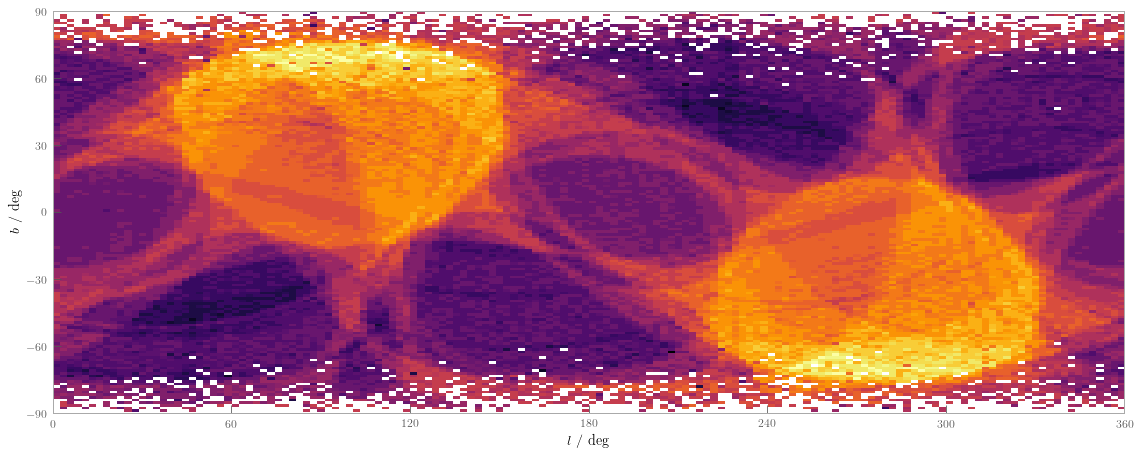

In [111]:
in_sb2 = in_sb2_source_parameter_range # for short.
fig = plot_average_grid_value(data["l"],
                              data["b"],
                              data["visibility_periods_used"],
                              bins=(150, 150), function=np.nanmedian,
                              subsample=500000, aspect=0.75, colorbar=False,
                              cmap="inferno", figsize=(16, 8),
                              xlabel=r"$l\,\,/\,\,\mathrm{deg}$",
                              ylabel=r"$b\,\,/\,\,\mathrm{deg}$",
                              zlabel="r\textrm{median visibility periods}")
fig.axes[0].set_xlim(0, 360)
fig.axes[0].set_ylim(-90, 90)
fig.axes[0].xaxis.set_major_locator(MaxNLocator(6))
fig.axes[0].yaxis.set_major_locator(MaxNLocator(6))

In [140]:
# Plot the source property distributions of the SB2 candidate systems relative to a control sample.

# For each SB2 candidate, we need to find the closest star in (bp - rp, apparent rp mag, absolute rp mag)
absolute_rp_mag = data["phot_rp_mean_mag"] + 5 * np.log10(data["parallax"]/100.0)
X = np.vstack([
    data["bp_rp"],
    data["phot_rp_mean_mag"],
    absolute_rp_mag
]).T

# Build a k-d tree using the stars that are NOT SB2s. 
# We can query this in parameter space that we care about to get the clsoest non-SB2.
import npm_utils as npm
finite = np.all(np.isfinite(X), axis=1)
kdt_indices = np.where(finite * ~is_sb2)[0]

kdt, scale, offset = npm.build_kdtree(X[kdt_indices], relative_scales=[0.1, 1.0, 1.0])
kdt_kwds = dict(offset=offset, scale=scale, minimum_points=1, maximum_points=1)

/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
  5%|▌         | 11405/215278 [03:37<1:04:39, 52.55it/s]

In [141]:
sb2_indices = np.arange(len(data))[is_sb2]
control_indices = np.nan * np.ones_like(sb2_indices)
K = sb2_indices.size

import tqdm
for i, index in tqdm.tqdm(enumerate(sb2_indices), total=K):
    try:
        indices_returned = list(kdt_indices[kdt.query(X[[index]], 1, return_distance=False)][0])
    
    except ValueError:
        continue
    
    control_indices[i] = indices_returned[0]


 57%|█████▋    | 122445/215278 [00:09<00:07, 12458.58it/s]
Exception in thread Thread-11:
Traceback (most recent call last):
  File "/Users/arc/anaconda2/envs/py3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 148, in run
    for instance in self.tqdm_cls._instances:
  File "/Users/arc/anaconda2/envs/py3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

100%|██████████| 215278/215278 [00:17<00:00, 12426.05it/s]


In [142]:
comp_subset = np.isfinite(control_indices)
subset_sb2_indices = sb2_indices[comp_subset]
subset_cnt_indices = control_indices[comp_subset].astype(int)

210779
210779


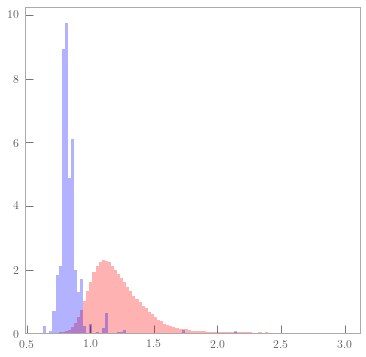

In [155]:
# astrometric unit weight error, phot_bp_rp_excess_factor
astrometric_unit_weight_error = np.sqrt(data["astrometric_chi2_al"]/(data["astrometric_n_obs_al"] - 5))
fig, ax = plt.subplots()

all_data = np.hstack([
    astrometric_unit_weight_error[subset_sb2_indices],
    astrometric_unit_weight_error[subset_cnt_indices]
]).flatten()
all_data = all_data[np.isfinite(all_data)]
bins = np.linspace(all_data.min(), 3, 100)

hist_kwds = dict(alpha=0.3, bins=bins, normed=True)
ax.hist(astrometric_unit_weight_error[subset_sb2_indices], facecolor="r", **hist_kwds)
_ = ax.hist(astrometric_unit_weight_error[subset_cnt_indices], facecolor="b", **hist_kwds)

print(np.sum(np.isfinite(astrometric_unit_weight_error[subset_sb2_indices])))
print(np.sum(np.isfinite(astrometric_unit_weight_error[subset_cnt_indices])))

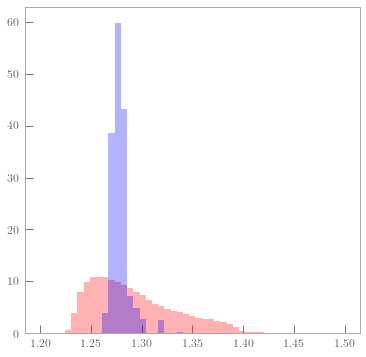

In [164]:
fig, ax = plt.subplots()

all_data = np.hstack([
    data["phot_bp_rp_excess_factor"][subset_sb2_indices],
    data["phot_bp_rp_excess_factor"][subset_cnt_indices]
]).flatten()
all_data = all_data[np.isfinite(all_data)]
bins = np.linspace(1.2, 1.5, 50)

hist_kwds = dict(alpha=0.3, bins=bins, normed=True)
ax.hist(data["phot_bp_rp_excess_factor"][subset_sb2_indices], facecolor="r", **hist_kwds)
_ = ax.hist(data["phot_bp_rp_excess_factor"][subset_cnt_indices], facecolor="b", **hist_kwds)


In [166]:
np.all(np.isfinite(data["phot_bp_rp_excess_factor"][subset_sb2_indices]))


True

/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1018: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


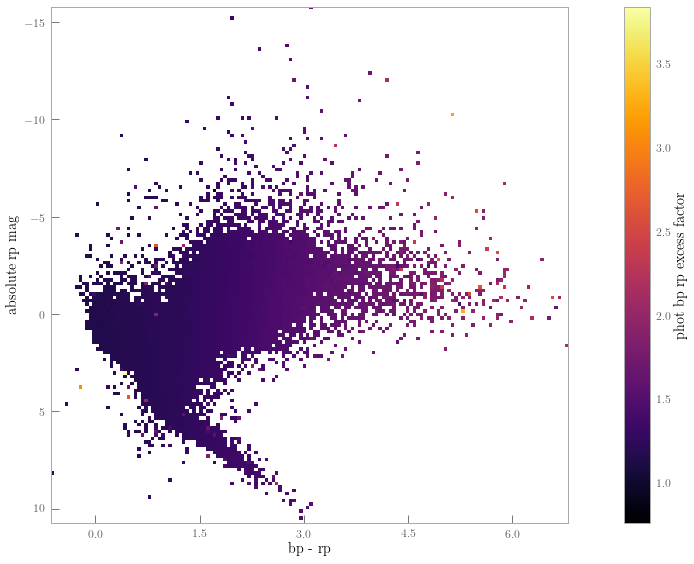

In [177]:
finite = np.isfinite(absolute_rp_mag * data["bp_rp"])
fig = plot_average_grid_value(data["bp_rp"][finite],
                              absolute_rp_mag[finite],
                              data["phot_bp_rp_excess_factor"][finite],
                              bins=(150, 150), function=np.nanmedian,
                              subsample=50000, colorbar=True,
                              cmap="inferno", figsize=(16, 8),
                              xlabel=r"\textrm{bp - rp}",
                              ylabel=r"\textrm{absolute rp mag}",
                              zlabel=r"\textrm{phot bp rp excess factor}")


In [152]:
comp_subset.sum()

210779

210779
210779


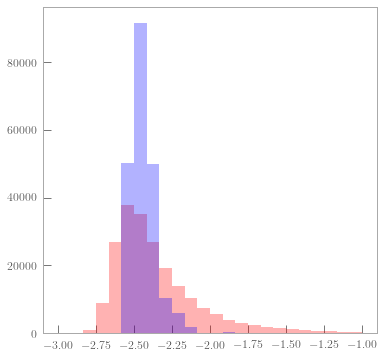

In [228]:
fig, ax = plt.subplots()

# photometric variability
d = np.log10(np.sqrt(data["astrometric_n_good_obs_al"]) * data["phot_g_mean_flux_error"] / data["phot_g_mean_flux"])

#bins = np.linspace(-3, -1, 100)# np.linspace(0, 1, 100) #  np.linspace(0, 2000, 20) # np.linspace(0, 2.5, 50)
bins = np.linspace(-3, -1, 25)

hist_kwds = dict(alpha=0.3, bins=bins)
v = d[subset_sb2_indices]
ax.hist(v[np.isfinite(v)], facecolor="r", **hist_kwds)
print(np.sum(np.isfinite(v)))

v = d[subset_cnt_indices]
_ = ax.hist(v[np.isfinite(v)], facecolor="b", **hist_kwds)
print(np.sum(np.isfinite(v)))



In [235]:
galah = fits.open("../data/GALAH_DR2.1_catalog.fits")[1].data

In [238]:
# see page 31 of https://arxiv.org/pdf/1804.06041.pdf
is_galah_binary = (galah["flag_cannon"] & 8) != 0

In [239]:
sum(is_galah_binary)

8655

In [240]:
set(galah["flag_cannon"][is_galah_binary])

{8, 9, 10, 11, 72, 73, 74, 75, 136, 137, 139, 201, 203}

In [244]:
galah_in_gaia = np.in1d(galah["gaia_dr2_id"], data["source_id"])

In [258]:
galah_indices = np.arange(len(galah))[galah_in_gaia]
gaia_indices = np.zeros(len(galah_indices))

In [ ]:
xi = np.arange(len(data))
G = len(galah_indices)
for i, galah_index in tqdm.tqdm(enumerate(galah_indices), total=G):
    gaia_index = xi[data["source_id"] == galah["gaia_dr2_id"][galah_index]]
        
    assert gaia_index.size == 1
    gaia_indices[i] = gaia_index[0]



  0%|          | 139/179089 [00:32<11:46:32,  4.22it/s]


  0%|          | 210/179089 [00:48<11:27:51,  4.33it/s]

In [256]:
xi

array([      0,       1,       2, ..., 8911261, 8911262, 8911263])